# Тема: Классификация портретов людей
Обучить модель распозновать 20 людей. Столько было в датасете.

## 1. Считаем данные из архива
Метки (labels) зашифрованы в названии картинок, парсим их оттуда.

In [2]:
import tarfile
import PIL
import io
import PIL.Image
import numpy as np

images = []
labels = []

class TarReader:
    __IMAGE_FILE_EXTENSION = '.pgm'
    __FILE_PATH_DELIMITER = '/'
    __ORIGINAL_SHAPE = (120, 128)

    def __init__(self, archivePath: str = 'faces.tar.gz'):
        self.path = archivePath

    def readImages(self, images: list, labels: list):
        with tarfile.open(self.path, 'r:gz') as tar:
            for member in tar.getmembers():
                if member.name.endswith(self.__IMAGE_FILE_EXTENSION):
                    file = tar.extractfile(member)
                    if file is not None:
                        fileName = member.name[:-len(self.__IMAGE_FILE_EXTENSION)].split(self.__FILE_PATH_DELIMITER)[-1]
                        str_features = fileName.split('_')
                        imgData = file.read()
                        img = PIL.Image.open(io.BytesIO(imgData))
                        imgArray = np.array(img)
                        if self.filterImages(imgArray, str_features):
                            images.append(imgArray)
                            labels.append(str_features)

    def filterImages(self, image: np.array, labels: list)-> bool:
        if image.shape != self.__ORIGINAL_SHAPE:
            return False
        return True
    
reader = TarReader()
reader.readImages(images, labels)

## 2. Создадим датафрейм со всеми метками и переведем их в числа

In [3]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd


labelNames = ['nickName', 'position', 'emotion', 'sunGlasses']
labelsDF = pd.DataFrame(columns=labelNames, data=labels)

name_encoder = LabelEncoder()
position_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
glasses_encoder = LabelEncoder()

labelsDF['nickName_int'] = name_encoder.fit_transform(labelsDF['nickName'])
labelsDF['position_int'] = position_encoder.fit_transform(labelsDF['position'])
labelsDF['emotion_int'] = emotion_encoder.fit_transform(labelsDF['emotion'])
labelsDF['sunGlasses_int'] = glasses_encoder.fit_transform(labelsDF['sunGlasses'])

labelsDF

,nickName,position,emotion,sunGlasses,nickName_int,position_int,emotion_int,sunGlasses_int
0,an2i,straight,neutral,open,0,2,2,0
1,an2i,left,neutral,open,0,0,2,0
2,an2i,right,neutral,open,0,1,2,0
3,an2i,up,neutral,open,0,3,2,0
4,an2i,straight,happy,open,0,2,1,0
...,...,...,...,...,...,...,...,...
619,tammo,up,sad,sunglasses,19,3,3,1
620,tammo,straight,angry,sunglasses,19,2,0,1
621,tammo,left,angry,sunglasses,19,0,0,1
622,tammo,right,angry,sunglasses,19,1,0,1


# 3. Посмотрим на исходные данные - картинки

## Все картинки имеют следующие лэйблы:
1. Никнейм человека (всего 20 человек)
2. Эмоция человека (всего 4 эмоции возможно: нейтральный, счастливый, грустный, злой)
3. Поза (возможно 4 позы: смотрит прямо, налево, направо, вверх)
4. Очки (человек в очках или нет)

Покажем для примера рандомные картинки из датасета:

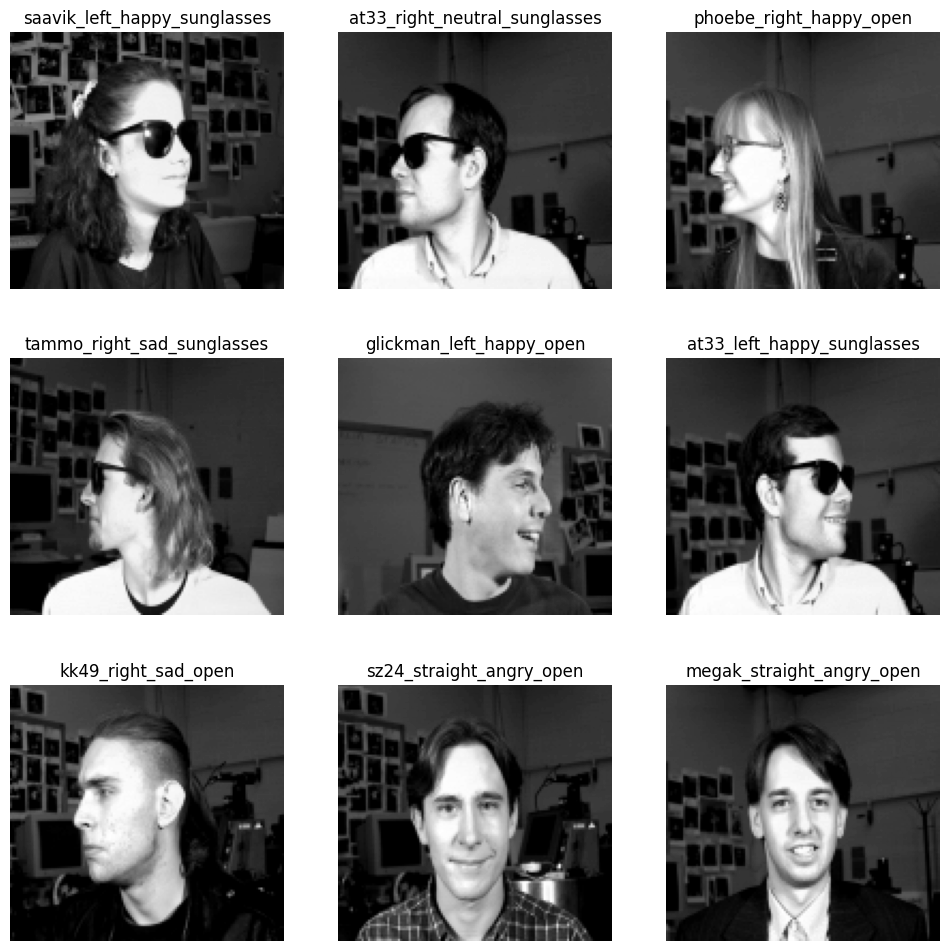

In [4]:
import matplotlib.pyplot as plt

def showRandowImages(n_rows, n_cols, images: list, labesl: list) -> None:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,12))
    for i, ax in enumerate(axes.flat):
        randomIndex = np.random.randint(0, len(images))
        image = images[randomIndex]
        label = labels[randomIndex]
        ax.imshow(image, cmap='gray')
        ax.set_title('_'.join(label))
        ax.axis('off')

showRandowImages(3,3, images, labels)

## 4. Произведем обработку картинок
1. Нормализация значения цвета ([0, 255] -> [0.0, 1.0])
2. Переведем из двумерного массива в одномерный
3. Понижение размерности путем использования алгоритма PCA (преобразование вектора длиной 15360 -> 300, путем вычленения главных компонент)

Обучаем алгоритм PCA только на тренировочных данных.

In [4]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(np.array(images), 
                                                    labelsDF['nickName_int'], 
                                                    test_size=0.2, 
                                                    random_state=42)

def normiliseImages(images: list):
    return np.array([image.flatten() / 256 for image in images])

X_train_norm = normiliseImages(X_train)
X_test_norm = normiliseImages(X_test)

pca = PCA(n_components=300)
pca.fit(X_train_norm)

X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

## 5. Обучим модель и проверим ее точность
В качестве модели использую SVM. Обучаю её на различных гипер-параметрах и выбираю лучшие при помощи GridSearchCV.

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns


def learnAndPredict(X_train, Y_train, X_test, Y_test):
    param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    # 'degree': [2, 3, 4],          # для 'poly' ядра
    # 'coef0': [0.0, 0.1, 0.5, 1]   # для 'poly' и 'sigmoid'
    }

    svc = SVC()

    grid_search = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,                
        n_jobs=-1           
    )

    grid_search.fit(X_train, Y_train)
    Y_pred = grid_search.predict(X_test)
    return grid_search, accuracy_score(Y_test, Y_pred)



fittedModel, testAccuracy = learnAndPredict(X_train_pca, Y_train, X_test_pca, Y_test)
print('accuracy on test data: ', testAccuracy)

accuracy on test data:  0.992


## Итоговая точность на тестовом наборе 0.992

## Можно попробовать попредсказывать имя для рандомной картинки из тестового набора

In [1]:
randInd = np.random.randint(0, len(X_test_pca))
randomImage = X_test_pca[randInd]
randomImagePredict = fittedModel.predict([randomImage])

plt.imshow(X_test[randInd], cmap='gray')
print('Предсказанное значени: ', name_encoder.inverse_transform([randomImagePredict[0]])[0])
print('Настоящее значение: ', name_encoder.inverse_transform([int(Y_test.reset_index().iloc[randInd]['nickName_int'])])[0])

NameError: name 'np' is not defined